In [24]:
import glob
import json
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

In [25]:
# %%time
# !jupyter nbconvert --to notebook --execute notebooks\045.ipynb --debug --inplace --ExecutePreprocessor.timeout=2678400

## 前処理ネタ

1. `name` に含まれる情報はクレンジングしておきたい
1. `name` の埋め込みベクトル、文字列長さ、単語数
  - `name` の言語はほぼ日本語、英語、中国語。まれにハングルがあるが両の手にすら満たない数かも。
    - 日本語 BERT: [cl-tohoku/bert-base-japanese-v2](https://huggingface.co/cl-tohoku/bert-base-japanese-v2).
    - 中国語 BERT: [bert-base-chinese](https://huggingface.co/bert-base-chinese), [hfl/chinese-bert-wwm-ext](https://huggingface.co/hfl/chinese-bert-wwm-ext).
  - FastText の言語識別モデルの結果は信用できそう。日本語英語中国語以外は英語で処理する。ハングルは90%超えたら信用できそうだ数は少ない。
  - [このノート](notebooks/nameって何語なの？.ipynb)
1. 今のレビュー数を得るのに何か月かかったのか
1. `host_id` のエンコーディング
    1. Frequency encoding
    1. レビュー履歴を集計する
    1. Cross table 集計で持っている物件の特徴を定量化（`neighbourhood`, `room_type` あたりがよさそう）
1. 最寄り駅 Top $N$ の名前と距離
    1. 駅名の重複に注意
    1. "押上（スカイツリー前）"、押上〈スカイツリー前〉の2つが存在するので注意（経度緯度は同じなので削除）
1. 経度緯度
    1. クラスタリングしてセントロイドからの距離を測る（場所が個性的度）
      - 多分クラスタ数は 9, 10 がちょうど良さそう
    1. 自身から $N$ の距離内の駅数（利便性の尺度？）
    1. 自身から $N$ の距離内の民泊数（競争過密度？）

1. 同じ価格の民泊がたくさんありそう？調べてみる。


## やってみたいこと

|No|CV|
|---:|:---|
|1|特徴量：`neighbourhood`, `latitude`, `longitude`, `room_type`, `minimum_nights`, `number_of_reviews`, `reviews_per_month`, `availability_365`, `review_date`, CV: StratifiedKfold(`neighborhood`), モデル：CatBoost|v
|2|特徴量：2 + `name` を train と test で共有されていなければ専用の値でマスク, CV: StratifiedKfold(`neighborhood`), モデル：CatBoost|
|3|特徴量：2 + `name` を Tf-IDF+LSIで64次元のベクトルに 
|4|特徴量：2 + `name` を Tf-IDF+LDAで64次元のベクトルに 
|5|特徴量：2 + `name` を Tf-IDF+NMFで64次元のベクトルに
|6|特徴量：2 + `name` を Tf-IDF+LSIで32次元のベクトルに 
|7|特徴量：2 + `name` を Tf-IDF+LDAで32次元のベクトルに 
|8|特徴量：2 + `name` を Tf-IDF+NMFで32次元のベクトルに
|9|特徴量：2 + `name` を Tf-IDF+LSIで16次元のベクトルに 
|10|特徴量：2 + `name` を Tf-IDF+LDAで16次元のベクトルに 
|11|特徴量：2 + `name` を Tf-IDF+NMFで16次元のベクトルに
|12|No.3 の Fold を StratifiedKFold(`y`を binning したやつ) + `name` はクレンジング|
|13|No.3 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|14|No.5 の Fold を StratifiedKFold(`y`を binning したやつ)+ `name` はクレンジング|
|15|No.5 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|16|No.6 の Fold を StratifiedKFold(`y`を binning したやつ)+ `name` はクレンジング|
|17|No.6 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|18|No.8 の Fold を StratifiedKFold(`y`を binning したやつ)+ `name` はクレンジング|
|19|No.8 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|20|No.5 に `name` のクレンジングを忘れていたので追加|
|21|No.20 に今のレビュー数を得るのに何か月かかったのかの特徴量を追加|
|22|No.14 に今のレビュー数を得るのに何か月かかったのかの特徴量を追加|
|23|No.15 に今のレビュー数を得るのに何か月かかったのかの特徴量を追加|
|24|No.20 にクラスタリングの特徴量を追加, クラスタ数は9|
|25|No.14 にクラスタリングの特徴量を追加, クラスタ数は9|
|26|No.15 にクラスタリングの特徴量を追加, クラスタ数は9|
|27|No.20 にクラスタリングの特徴量を追加, クラスタ数は10|
|28|No.14 にクラスタリングの特徴量を追加, クラスタ数は10|
|29|No.15 にクラスタリングの特徴量を追加, クラスタ数は10|
|30|No.20 に最寄り駅の特徴量を追加|
|31|No.14 に最寄り駅の特徴量を追加|
|32|No.15 に最寄り駅の特徴量を追加|
|33|No.20 に近くの民泊数の特徴量を追加|
|34|No.14 に近くの民泊数の特徴量を追加|
|35|No.15 に近くの民泊数の特徴量を追加|
|36|No.20 + `name` を Bert pretrained model で埋め込みにしたもの|
|37|No.14 + `name` を Bert pretrained model で埋め込みにしたもの|
|38|No.15 + `name` を Bert pretrained model で埋め込みにしたもの|
|39|No.20 + `name` を言語に応じた Bert pretrained model で埋め込みにしたもの|
|40|No.14 + `name` を言語に応じた Bert pretrained model で埋め込みにしたもの|
|41|No.15 + `name` を言語に応じた Bert pretrained model で埋め込みにしたもの|
|42|No.20 + `name` を言語に応じた Tokenization を掛けてから TF-IDF して NMF で64次元にするもの|
|43|No.14 + `name` を言語に応じた Tokenization を掛けてから TF-IDF して NMF で64次元にするもの|
|44|No.15 + `name` を言語に応じた Tokenization を掛けてから TF-IDF して NMF で64次元にするもの|
|45|No.20 + `host_id` をエンコード|
|46|No.14 + `host_id` をエンコード|
|47|No.15 + `host_id` をエンコード|

- 2022-04-28  
  - No.11 まで実施するも CV vs LB の並びが気に食わない。相関は強そうだがロスに差があるのはさておき順位が一致しないのが気持ち悪い。StratifiedKFold(`neighbourhood`)以外の方法も試して信頼できる CV を探したい。No.3, 5, 6, 8 を対象に以下を試す。
    - StratifiedKFold: `y`を binning して bin を層とみなす
    - GroupKFold(`host_id`): [このDiscussion](https://comp.probspace.com/competitions/bnb_price/discussions/shirapon24-Postde0ee1e20bc5d402eea0) でやってる人がいる。

- 2022-04-30  
  - No.12-19 を行い5サブ使って CV と LB の相関を確認する。相関はしているが CV と LB とで順位が合わないことがあり気持ち悪い。
  - No.44 までつらつらと書き連ねた。
  - 今のレビュー数を得るのに何か月かかったのかの特徴量は無い方が良い？
  - 同じ `name` で場所も同じっぽいのに `host_id` が違うと価格が大きく変わることがある。`host_id` から予測に役立つ情報をどう抽出するのか？を考えられたらスコア大きく伸びるかも？
  - No.19 以降は表の番号と実際のノートがあっていないかもしれないから要チェック。
  
- 2022-05-01
  - 024 の途中で `name` のクレンジングを間違えて test の一部が欠損していることに気づいたから修正した
  
- 2022-05-02
  - CV と LB がまるで一致しない。

## CV vs LB

In [26]:
lb = [
    ('001', 0.86378),
    ('002', np.nan),  # `y` を対数変換せずに学習して Submit したので他と比べられない
    ('003', 0.82206),
    ('004', 0.85716),
    ('005', 0.80957),
    ('006', 0.82747),
    ('007', 0.84814),
    ('008', 0.82104),
    ('009', 0.83919),
    ('010', 0.86311),
    ('011', 0.83046),
    ('012', 0.82092),
    ('013', 0.82579),
    ('014', 0.80827),
    ('015', 0.80948),
    ('016', 0.82307),
    ('017', 0.83054),
    ('018', 0.81970),
    ('019', 0.82118),
    ('020', 0.80767),
    ('021', 0.80968),
    ('023', 0.80532),
    ('026', 0.80728),
    ('029', 0.80773),
    ('027', 0.80365),
    ('032', 0.81128),
    ('036', 0.82111),
    ('033', 0.80234),
    ('042', 0.80917),
    ('039', 0.81531),
    ('045', 0.82435)

]
lb = pd.DataFrame(lb, columns=['No', 'LB'])
assert not lb['No'].duplicated().any()
lb

,No,LB
0,001,0.86378
1,002,NaN
2,003,0.82206
3,004,0.85716
4,005,0.80957
5,006,0.82747
6,007,0.84814
7,008,0.82104
8,009,0.83919
9,010,0.86311


In [27]:
cv = []
for filepath in glob.glob(os.path.join('notebooks', '*', 'result.json')):
    with open(filepath, 'r') as f:
        cv.append(json.load(f))
cv = pd.DataFrame(cv)
cv

,No,CV,Fold
0,001,0.694386,NaN
1,002,0.697720,NaN
2,003,0.589649,NaN
3,004,0.667733,NaN
4,005,0.590896,NaN
5,006,0.600847,NaN
6,007,0.674444,NaN
7,008,0.604754,NaN
8,009,0.610643,NaN
9,010,0.677813,NaN


In [28]:
cv_vs_lb = pd.merge(cv, lb, how='left').set_index('No')
cv_vs_lb['Fold'].fillna('StratifiedKFold(neighbourhood)', inplace=True)
cv_vs_lb['Rank(CV)'] = cv_vs_lb['CV'].rank().astype('int')
cv_vs_lb['Rank(LB)'] = cv_vs_lb['LB'].rank()
cv_vs_lb = cv_vs_lb[['Fold', 'CV', 'LB', 'Rank(CV)', 'Rank(LB)']]
cv_vs_lb.sort_values(['Fold', 'Rank(CV)'])

,Fold,CV,LB,Rank(CV),Rank(LB)
No,,,,,
015,GroupKFold(host_id),0.808273,0.80948,34,9.0
026,GroupKFold(host_id),0.812896,0.80728,35,4.0
035,GroupKFold(host_id),0.813404,NaN,36,NaN
032,GroupKFold(host_id),0.813653,0.81128,37,12.0
029,GroupKFold(host_id),0.813925,0.80773,38,6.0
044,GroupKFold(host_id),0.818351,NaN,39,NaN
023,GroupKFold(host_id),0.820614,0.80532,40,3.0
017,GroupKFold(host_id),0.825099,0.83054,41,25.0
013,GroupKFold(host_id),0.830990,0.82579,42,22.0


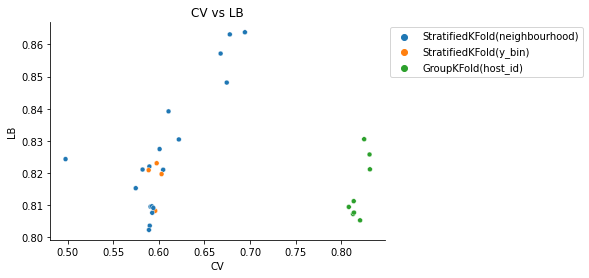

In [29]:
fig, _ = plt.subplots(nrows=1, ncols=1, sharex=True,sharey=True)
ax = sns.scatterplot(data=cv_vs_lb, x='CV', y='LB', hue='Fold', s=24)
ax.legend(loc='upper left', bbox_to_anchor=[1., 1.])
ax.set_title('CV vs LB')
sns.despine()

In [30]:
cv_vs_lb.groupby('Fold').corr()

CV        LB  Rank(CV)  \
Fold                                                                    
GroupKFold(host_id)            CV        1.000000  0.759515  0.880589   
                               LB        0.759515  1.000000  0.685056   
                               Rank(CV)  0.880589  0.685056  1.000000   
                               Rank(LB)  0.713281  0.985139  0.646039   
StratifiedKFold(neighbourhood) CV        1.000000  0.753871  0.855696   
                               LB        0.753871  1.000000  0.693938   
                               Rank(CV)  0.855696  0.693938  1.000000   
                               Rank(LB)  0.550836  0.923898  0.596027   
StratifiedKFold(y_bin)         CV        1.000000 -0.007198  0.680193   
                               LB       -0.007198  1.000000 -0.147948   
                               Rank(CV)  0.680193 -0.147948  1.000000   
                               Rank(LB)  0.027008  0.952918 -0.015250   

                                         Rank(LB)  
Fold                                               
GroupKFold(host_id)            CV        0.713281  
                               LB        0.985139  
                               Rank(CV)  0.646039  
                               Rank(LB)  1.000000  
StratifiedKFold(neighbourhood) CV        0.550836  
                               LB        0.923898  
                               Rank(CV)  0.596027  
                               Rank(LB)  1.000000  
StratifiedKFold(y_bin)         CV        0.027008  
                               LB        0.952918  
                               Rank(CV) -0.015250  
                               Rank(LB)  1.000000

## Submissions

In [31]:
submissions = []
for filepath in glob.glob(os.path.join('notebooks', '*', 'submission*.csv')):
    sub = pd.read_csv(filepath).set_index('id').rename(columns={'y': os.path.basename(filepath).replace('.csv', '')})
    submissions.append(sub)
submissions = pd.concat(submissions, axis=1)
submissions

,submission_001,submission_002,submission_003,submission_004,submission_005,submission_006,submission_007,submission_008,submission_009,submission_010,...,submission_036,submission_039,submission_040,submission_041,submission_042,submission_043,submission_044,submission_045,submission_046,submission_047
id,,,,,,,,,,,,,,,,,,,,,
1,15563.757288,15412.997055,15149.523135,13178.117184,11980.825061,10508.393906,15667.459837,11324.098572,12065.894615,14905.229225,...,10282.161498,11905.426337,11276.138608,11836.879891,16516.308180,13895.445585,15443.504873,12570.878817,13688.446081,13952.184565
2,11315.311473,11800.884838,16759.002170,18896.921538,17543.344321,18547.891042,15522.055171,19381.293858,13768.671233,13016.722028,...,13441.222715,17146.895172,16463.988248,14916.523661,16374.591184,17752.772203,17387.700527,18866.241642,19355.021083,20971.350418
3,15921.739860,15458.861373,12868.850477,13833.183047,8661.947943,14978.764058,14609.431020,12749.191746,14776.633311,13855.485504,...,11830.817446,13320.604275,14329.091326,13087.245952,10868.642027,10662.848943,11348.711496,19658.004670,20008.923662,19092.748666
4,18301.790676,17935.568540,18215.072414,18200.361440,13063.205844,17165.856038,13294.381434,11831.085654,13983.897808,16297.975643,...,13036.876550,12201.468312,12593.728845,12142.766266,12186.777406,12343.308913,12102.914749,9966.755199,10167.669312,10085.250807
5,16902.712775,17462.485144,13713.515681,10807.210259,17727.311670,16046.239749,10672.610902,19578.740872,13694.180372,12693.326009,...,10645.387898,11305.019668,11893.337610,12634.807447,15796.648612,16247.953556,15895.335543,13533.220389,12969.601648,13702.027220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,16205.214315,17100.410596,16314.733135,15171.650792,19556.640976,14094.964825,16362.980911,13140.105071,13840.264147,15989.095466,...,14843.449094,16568.966180,17394.554996,17811.357380,22853.956736,22883.965658,21080.537893,19741.986266,21197.243630,18850.815601
4993,5677.865217,5358.291104,5948.367432,3948.394058,7428.852594,5898.345846,4168.222473,5514.551350,5488.185618,4596.088497,...,5598.665392,5554.010795,5956.698103,6153.173525,6914.133166,6839.563483,6331.501550,6030.645840,6019.950359,6043.106272
4994,12993.019405,13360.993708,12191.612305,8989.510602,9128.376238,10654.646137,14195.483591,13188.754774,9980.230906,14370.268756,...,7766.631860,8735.154083,7492.541932,8304.190858,8081.599540,7562.692136,7998.165754,10137.364838,9584.841156,10144.765092


In [32]:
corr = submissions.corr()
corr

,submission_001,submission_002,submission_003,submission_004,submission_005,submission_006,submission_007,submission_008,submission_009,submission_010,...,submission_036,submission_039,submission_040,submission_041,submission_042,submission_043,submission_044,submission_045,submission_046,submission_047
submission_001,1.000000,0.992997,0.636294,0.709383,0.539525,0.626795,0.742152,0.614587,0.669529,0.777660,...,0.541855,0.544301,0.553530,0.572293,0.545507,0.535441,0.587243,0.598047,0.605180,0.608573
submission_002,0.992997,1.000000,0.638716,0.713171,0.538779,0.627931,0.746296,0.615483,0.670174,0.781966,...,0.544469,0.545379,0.555038,0.573979,0.545414,0.535220,0.588972,0.601310,0.609623,0.612106
submission_003,0.636294,0.638716,1.000000,0.745140,0.703509,0.924160,0.729231,0.812588,0.885452,0.726250,...,0.768894,0.762243,0.785504,0.789407,0.720122,0.702304,0.758545,0.764182,0.767534,0.743939
submission_004,0.709383,0.713171,0.745140,1.000000,0.599688,0.734037,0.872784,0.685876,0.737677,0.882376,...,0.659136,0.656403,0.670952,0.699042,0.611981,0.598340,0.662568,0.707845,0.710326,0.713535
submission_005,0.539525,0.538779,0.703509,0.599688,1.000000,0.672951,0.584961,0.826826,0.640432,0.607285,...,0.866964,0.887785,0.872253,0.852444,0.964482,0.956700,0.944205,0.572614,0.570635,0.558242
submission_006,0.626795,0.627931,0.924160,0.734037,0.672951,1.000000,0.724703,0.820976,0.932568,0.725500,...,0.750394,0.743315,0.764881,0.781395,0.692175,0.677475,0.739773,0.778794,0.778633,0.761645
submission_007,0.742152,0.746296,0.729231,0.872784,0.584961,0.724703,1.000000,0.681112,0.736974,0.890258,...,0.643685,0.638092,0.649122,0.679990,0.592479,0.581981,0.644472,0.703383,0.705625,0.707313
submission_008,0.614587,0.615483,0.812588,0.685876,0.826826,0.820976,0.681112,1.000000,0.787521,0.692764,...,0.843058,0.848611,0.846357,0.852567,0.849983,0.843159,0.871498,0.701069,0.693856,0.684480
submission_009,0.669529,0.670174,0.885452,0.737677,0.640432,0.932568,0.736974,0.787521,1.000000,0.747692,...,0.720052,0.717006,0.740934,0.755106,0.658839,0.647569,0.711518,0.772425,0.778069,0.767122
submission_010,0.777660,0.781966,0.726250,0.882376,0.607285,0.725500,0.890258,0.692764,0.747692,1.000000,...,0.658751,0.658560,0.667730,0.696243,0.622632,0.619897,0.669150,0.703689,0.706183,0.703904


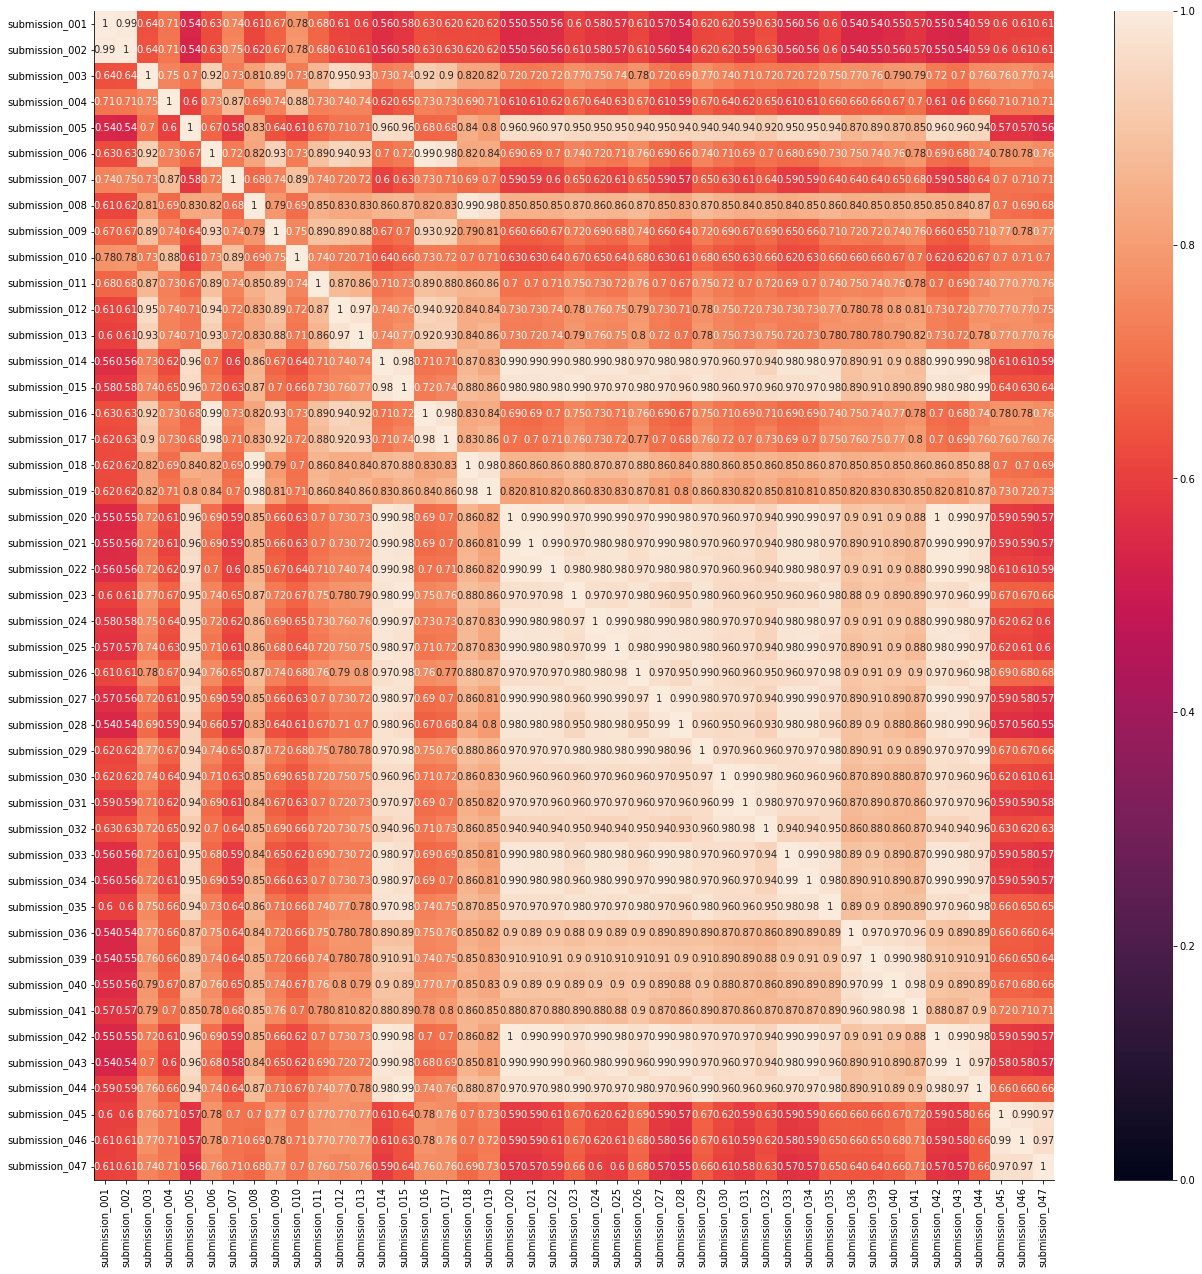

In [33]:
fig = plt.figure(figsize=(21.5, 21.5))
sns.heatmap(corr, annot=True, vmin=0., vmax=1.)
sns.despine()